# US Consumer Finance Complaints

  In this exercise I build different architectures to do text classification on the US Consumer Finance Complaints Data, and the performance of the architectures is compared. The architectures being compared include Bidirectional LSTM, LSTM with TBPTT, Multilayered GRU, and single layer CNN with variable filter widths. These architectures are compared with single LSTM, stacked CNN, Naive Bayes (NB), and Logistic Regression (LR), and it turns out that Logistic Regression had the best performance.

  On the other hand, CNN-based networks also do not perform well, which means word order in a text really matters in this one. The worst performing network is the single layered CNN with variable-length filters, but this network can be improved by stacking up conv layers as well as fine-tuning filter sizes.
  
  One conclusion to draw from this exercise is to always compare deep learning architectures with classical algorithms such as NB and LR, and many people, including researchers, tend to skip this step. If a problem can be solved using non-deep algorithms, there is no need for expensive computations of deep nets.

### Constants

In [11]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6b')
TEXT_DATA_DIR = os.path.join(BASE_DIR, 'consumer_complaints.csv')
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.4

### Packages

In [12]:
import pandas as pd
import re
import itertools
import string
from io import BytesIO
from collections import Counter
from time import time
import datetime
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils import to_categorical

/home/longw/.virtualenvs/yolo_py3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data Preprocessing

In [3]:
def data_preprocessing(texts, labels, indices, num_validation_samples, classifier="NeuralNetwork"):
    
    word_index = None
    
    if classifier == "NeuralNetwork":
        tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)
        
        plt.figure()
        plt.hist([len(x) for x in sequences])
        plt.xlabel('Length of Document')
        plt.ylabel('Number of Documents')
        plt.title('Statistic of Data')
        plt.grid(True)
        plt.show()
        
        word_index = tokenizer.word_index
        
        with open('tokenizer.pickle', 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
        
    else:
        vectorizer = TfidfVectorizer()
        data = vectorizer.fit_transform(texts)
    
    labels = to_categorical(np.asarray(labels))  
    data = data[indices]
    labels = labels[indices]

    x_train = data[:-num_validation_samples]
    y_train = labels[:-num_validation_samples]
    x_val = data[-num_validation_samples:]
    y_val = labels[-num_validation_samples:]
    
    return x_train, y_train, x_val, y_val, word_index        

In [13]:
def clean_str(string):
    """
    Tokenization/string cleaning (partially modified)
    """
    string = re.sub(r"[^A-Za-z0-9()!?\'\`%$]", " ", string) # keep also %$ but removed comma
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\$", " $ ", string) #yes, isolate $
    string = re.sub(r"\%", " % ", string) #yes, isolate %
    string = re.sub(r"\s{2,}", " ", string)
    
    # fixing XXX and xxx like as word
    string = re.sub(r'\S*(x{2,}|X{2,})\S*',"xxx",string)
    # removing non ascii
    string = re.sub(r'[^\x00-\x7F]+', "", string) 
    
    return string.strip().lower()

In [14]:
def get_complaints(path):
    
    # Read the input dataset 
    d = pd.read_csv(path, 
                    usecols=('product','consumer_complaint_narrative'),
                    dtype={'consumer_complaint_narrative': object})
    # Only interested in data with consumer complaints
    d=d[d['consumer_complaint_narrative'].notnull()]
    d=d[d['product'].notnull()]
    d.reset_index(drop=True,inplace=True)
    d['consumer_complaint_narrative'] = d['consumer_complaint_narrative'].apply(clean_str)
    
    le = preprocessing.LabelEncoder()
    label_name = d['product'].tolist()
    le.fit(label_name)
    d['label'] = le.transform(label_name)
    
    labels_index = dict(zip(list(le.classes_), range(len(le.classes_))))
    return d['consumer_complaint_narrative'].tolist(), labels_index, d['label'].tolist()

In [15]:
texts, labels_index, labels = get_complaints(TEXT_DATA_DIR)

In [16]:
indices_consumer = np.arange(len(texts))
np.random.shuffle(indices_consumer)
num_validation_samples_c = int(VALIDATION_SPLIT * len(texts))

In [17]:
experiment_result_c = dict()

### SKLEARN

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [52]:
x_train, y_train, x_val, y_val, _ = data_preprocessing(texts, 
                                                       labels, 
                                                       indices_consumer, 
                                                       num_validation_samples_c, 
                                                       classifier="SKLEARN")

In [53]:
clf =  MultinomialNB(alpha=0.1)
clf.fit(x_train, np.argmax(y_train, axis=1))
pred = clf.predict(x_val)
experiment_result_c['NB'] = metrics.accuracy_score(np.argmax(y_val, axis=1), pred)

In [1]:
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

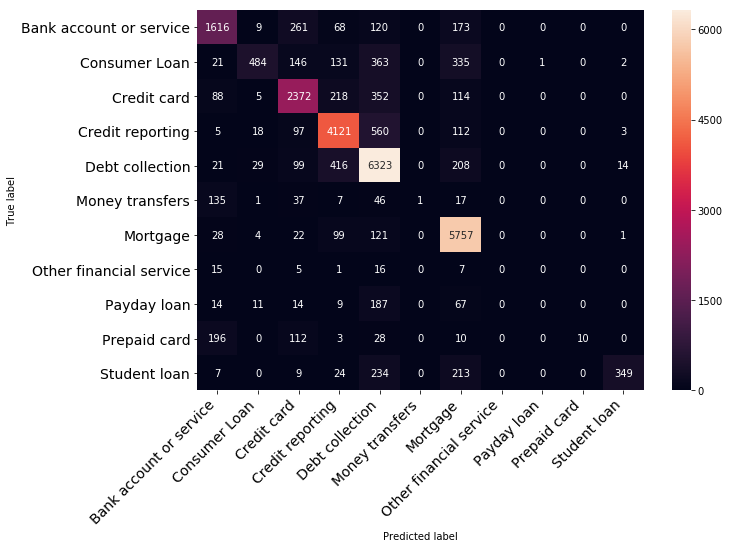

In [54]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), pred), 
                       sorted(labels_index.keys()))

In [55]:
clf =  LogisticRegression()
clf.fit(x_train, np.argmax(y_train, axis=1))
pred = clf.predict(x_val)
experiment_result_c['LR'] = metrics.accuracy_score(np.argmax(y_val, axis=1), pred)

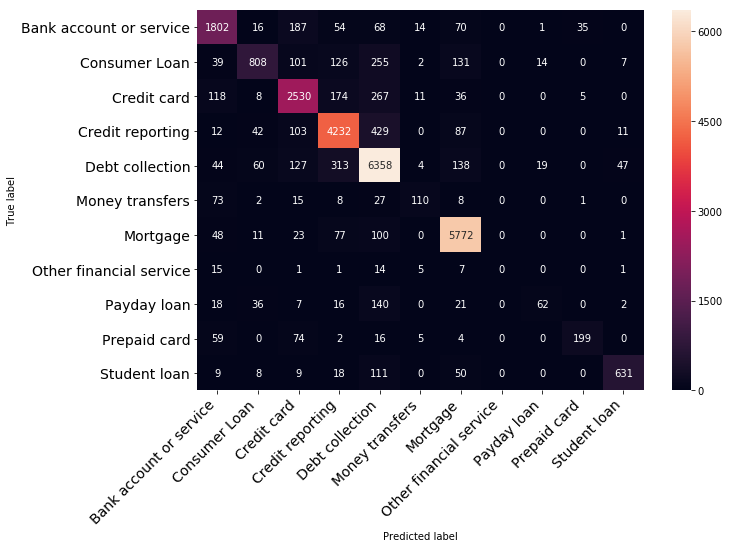

In [56]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), pred), 
                        sorted(labels_index.keys()))

### Tensorflow

In [6]:
from tensorflow.python.keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, GRU, Concatenate, Dropout
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K

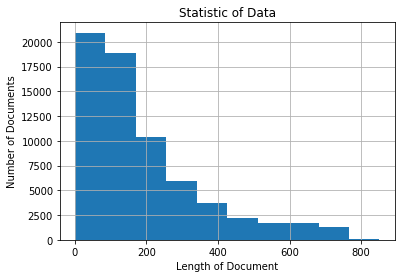

In [69]:
x_train, y_train, x_val, y_val, word_index = data_preprocessing(texts, 
                                                                labels, 
                                                                indices_consumer, 
                                                                num_validation_samples_c, 
                                                                classifier="NeuralNetwork")

In [7]:
def get_embedding_matrix(word_index):
    
    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)), encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, num_words

In [70]:
embedding_matrix, num_words = get_embedding_matrix(word_index)

### CNN

In [71]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

graph = tf.get_default_graph()
with graph.as_default():
    #Pretrained
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a 1D convnet with global maxpooling
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=20, # Change this to at least 20 for final run
                        validation_data=(x_val, y_val))

Training model.
Train on 40084 samples, validate on 26722 samples
Epoch 1/20
40084/40084 [==============================]40084/40084 [==============================] - 253s 6ms/step - loss: 1.2809 - acc: 0.5720 - val_loss: 1.0619 - val_acc: 0.6611

Epoch 2/20
40084/40084 [==============================]40084/40084 [==============================] - 227s 6ms/step - loss: 0.8068 - acc: 0.7498 - val_loss: 1.1573 - val_acc: 0.6451

Epoch 3/20
40084/40084 [==============================]40084/40084 [==============================] - 214s 5ms/step - loss: 0.6495 - acc: 0.7987 - val_loss: 0.6893 - val_acc: 0.7897

Epoch 4/20
40084/40084 [==============================]40084/40084 [==============================] - 226s 6ms/step - loss: 0.5573 - acc: 0.8288 - val_loss: 0.5947 - val_acc: 0.8211

Epoch 5/20
40084/40084 [==============================]40084/40084 [==============================] - 175s 4ms/step - loss: 0.4914 - acc: 0.8455 - val_loss: 0.5843 - val_acc: 0.8251

Epoch 6/20
40084/40

In [5]:
def show_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

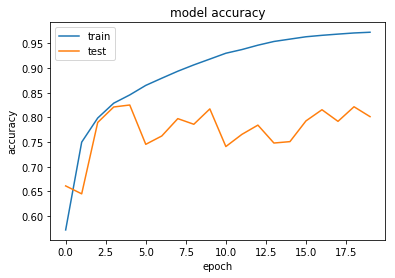

In [74]:
show_curve(history)

In [76]:
pred = model.predict(x_val)
experiment_result_c['CNN'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

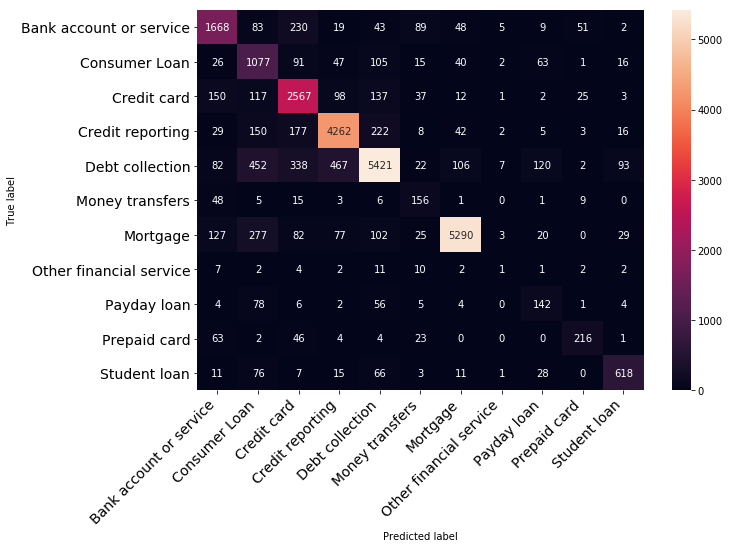

In [77]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                        sorted(labels_index.keys()))

### LSTM

In [23]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a single layer LSTM recurrent neural network
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    # Replace LSTM with GRU if you want
    x,_,_ = LSTM(EMBEDDING_DIM, return_state=True)(embedded_sequences)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=20, # Change this to at least 20 for final run
                      validation_data=(x_val, y_val))

Training model.
Train on 40084 samples, validate on 26722 samples
Epoch 1/20
40084/40084 [==============================]40084/40084 [==============================] - 179s 4ms/step - loss: 1.6376 - acc: 0.4229 - val_loss: 1.4693 - val_acc: 0.4988

Epoch 2/20
40084/40084 [==============================]40084/40084 [==============================] - 174s 4ms/step - loss: 0.9878 - acc: 0.6826 - val_loss: 0.9045 - val_acc: 0.7176

Epoch 3/20
40084/40084 [==============================]40084/40084 [==============================] - 177s 4ms/step - loss: 0.7765 - acc: 0.7561 - val_loss: 0.8925 - val_acc: 0.7237

Epoch 4/20
40084/40084 [==============================]40084/40084 [==============================] - 173s 4ms/step - loss: 0.6654 - acc: 0.7917 - val_loss: 0.6875 - val_acc: 0.7876

Epoch 5/20
40084/40084 [==============================]40084/40084 [==============================] - 173s 4ms/step - loss: 0.5997 - acc: 0.8127 - val_loss: 0.6303 - val_acc: 0.8039

Epoch 6/20
40084/40

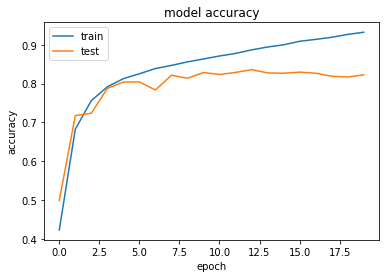

In [24]:
show_curve(history)

In [26]:
    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=10,
                      validation_data=(x_val, y_val))

Train on 40084 samples, validate on 26722 samples
Epoch 1/10
40084/40084 [==============================]40084/40084 [==============================] - 177s 4ms/step - loss: 0.1733 - acc: 0.9433 - val_loss: 0.8418 - val_acc: 0.8165

Epoch 2/10
40084/40084 [==============================]40084/40084 [==============================] - 173s 4ms/step - loss: 0.1561 - acc: 0.9484 - val_loss: 0.9015 - val_acc: 0.8183

Epoch 3/10
40084/40084 [==============================]40084/40084 [==============================] - 179s 4ms/step - loss: 0.1447 - acc: 0.9516 - val_loss: 0.9598 - val_acc: 0.8266

Epoch 4/10
40084/40084 [==============================]40084/40084 [==============================] - 173s 4ms/step - loss: 0.1296 - acc: 0.9572 - val_loss: 1.0141 - val_acc: 0.8148

Epoch 5/10
40084/40084 [==============================]40084/40084 [==============================] - 173s 4ms/step - loss: 0.1157 - acc: 0.9616 - val_loss: 1.0843 - val_acc: 0.7948

Epoch 6/10
40084/40084 [===========

In [27]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result_c['RNN'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

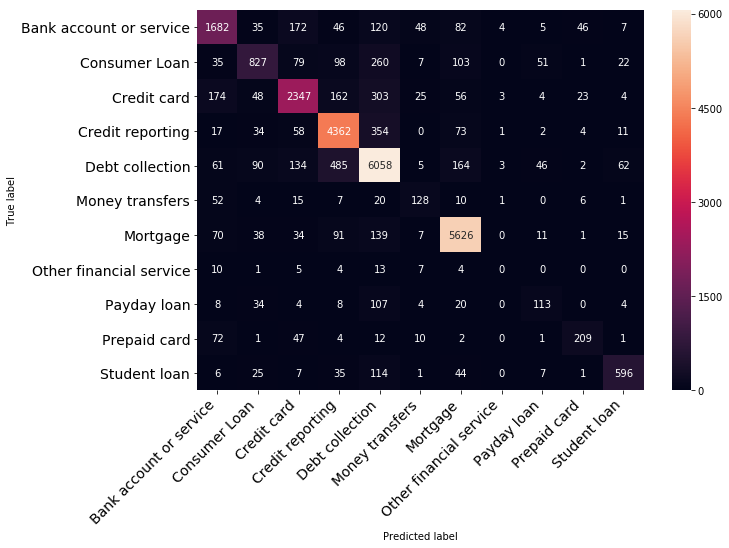

In [28]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                        sorted(labels_index.keys()))

### Bidirectional LSTM + LSTM

In [30]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()
with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train 2 Layer LSTM model with first LSTM to bidirectional
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x1 = LSTM(EMBEDDING_DIM, return_sequences=True)(embedded_sequences)
    x2 = LSTM(EMBEDDING_DIM, return_sequences=True, go_backwards=True)(embedded_sequences)
    x = Concatenate()([x1, x2])
    x,_,_ = LSTM(EMBEDDING_DIM, return_state=True)(x) # Note: this layer takes previous LSTM layer as input!
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history = model.fit(x_train, y_train,
                         batch_size=128,
                         epochs=20, # Change this to at least 20 for final run
                         validation_data=(x_val, y_val))

Training model.
Train on 40084 samples, validate on 26722 samples
Epoch 1/20
40084/40084 [==============================]40084/40084 [==============================] - 580s 14ms/step - loss: 1.7238 - acc: 0.3962 - val_loss: 1.5172 - val_acc: 0.4754

Epoch 2/20
40084/40084 [==============================]40084/40084 [==============================] - 580s 14ms/step - loss: 1.2971 - acc: 0.5791 - val_loss: 1.1966 - val_acc: 0.6215

Epoch 3/20
40084/40084 [==============================]40084/40084 [==============================] - 581s 14ms/step - loss: 0.9387 - acc: 0.7020 - val_loss: 0.9106 - val_acc: 0.7117

Epoch 4/20
40084/40084 [==============================]40084/40084 [==============================] - 581s 14ms/step - loss: 0.7696 - acc: 0.7572 - val_loss: 0.7486 - val_acc: 0.7638

Epoch 5/20
40084/40084 [==============================]40084/40084 [==============================] - 581s 15ms/step - loss: 0.6602 - acc: 0.7925 - val_loss: 0.7528 - val_acc: 0.7665

Epoch 6/20
400

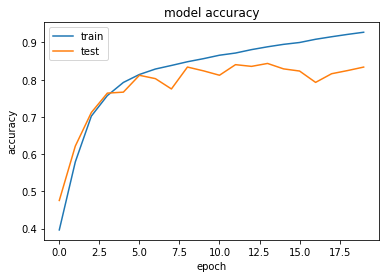

In [35]:
show_curve(history)

In [33]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result_c['BRNN'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

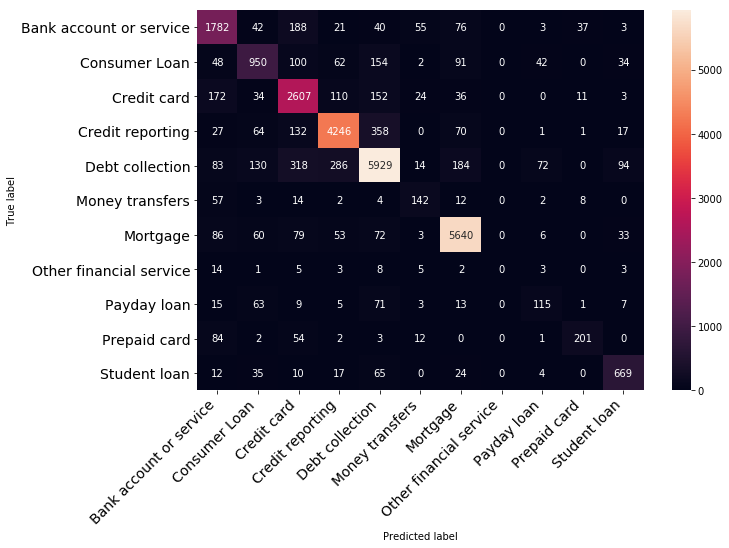

In [34]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                       sorted(labels_index.keys()))

### Train Simple RNN with Truncated Backprop Through Time (TBPTT) 

In [41]:
MAX_SEQUENCE_LENGTH = 100 # Chunk size for TBPTT

In [9]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [10]:
def data_preprocessing_v2(texts, labels, word_index, indices, num_validation_samples, classifier="NeuralNetwork"):
    
    word_index = None
    
    new_sequences = []
    new_labels = []
    
    texts = [texts[i] for i in indices]
    labels = [labels[i] for i in indices]
    texts = texts[:-num_validation_samples]
    labels = labels[:-num_validation_samples]
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    print(len(tokenizer.word_index))
    sequences = tokenizer.texts_to_sequences(texts)

    for index, sequence in enumerate(sequences):
        split_sequence = list(chunks(sequence, 100)) # Break sequences into 100-length chunks for training!
        label = labels[index]
        new_sequences += split_sequence
        new_labels += [label]*len(split_sequence)

    print(len(new_sequences), len(new_labels))

    sequences = new_sequences
    labels = new_labels

    plt.figure()
    plt.hist([len(x) for x in sequences])
    plt.xlabel('Length of Document')
    plt.ylabel('Number of Documents')
    plt.title('Statistic of Data')
    plt.grid(True)
    plt.show()

    word_index = tokenizer.word_index
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    labels = to_categorical(np.asarray(labels))  
    
    return data, labels    

52942
97125 97125


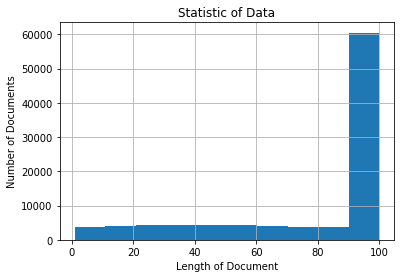

In [42]:
x_train, y_train = data_preprocessing_v2(texts, 
                                         labels,
                                         word_index,
                                         indices_consumer,
                                         num_validation_samples_c)

In [44]:
indices_consumer

array([21342, 26775, 41552, ..., 26837, 13550, 10136])

In [45]:
x_train.shape

(97125, 100)

In [46]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a single layer LSTM recurrent neural network
    sequence_input = Input(shape=(None,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    # Replace LSTM with GRU if you want
    x,_,_ = LSTM(EMBEDDING_DIM, return_state=True)(embedded_sequences)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=20, # Change this to at least 20 for final run
                      validation_data=(x_val, y_val))

Training model.
Train on 97125 samples, validate on 26722 samples
Epoch 1/20
97125/97125 [==============================]97125/97125 [==============================] - 112s 1ms/step - loss: 1.3694 - acc: 0.5328 - val_loss: 0.8322 - val_acc: 0.7381

Epoch 2/20
97125/97125 [==============================]97125/97125 [==============================] - 111s 1ms/step - loss: 0.9412 - acc: 0.6951 - val_loss: 0.6536 - val_acc: 0.7943

Epoch 3/20
97125/97125 [==============================]97125/97125 [==============================] - 110s 1ms/step - loss: 0.8396 - acc: 0.7285 - val_loss: 0.5761 - val_acc: 0.8194

Epoch 4/20
97125/97125 [==============================]97125/97125 [==============================] - 110s 1ms/step - loss: 0.7858 - acc: 0.7454 - val_loss: 0.5484 - val_acc: 0.8286

Epoch 5/20
97125/97125 [==============================]97125/97125 [==============================] - 114s 1ms/step - loss: 0.7469 - acc: 0.7574 - val_loss: 0.5371 - val_acc: 0.8335

Epoch 6/20
97125/97

In [47]:
MAX_SEQUENCE_LENGTH = 500

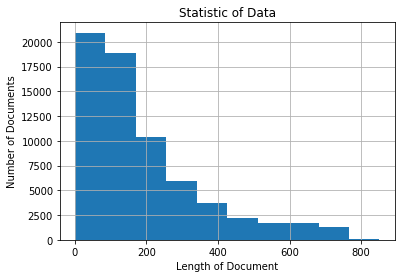

In [48]:
_, _, x_val, y_val, word_index = data_preprocessing(texts, 
                                                                labels,  
                                                                indices_consumer,
                                                                num_validation_samples_c, 
                                                                classifier="NeuralNetwork")

In [49]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result_c['RNN-Short'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

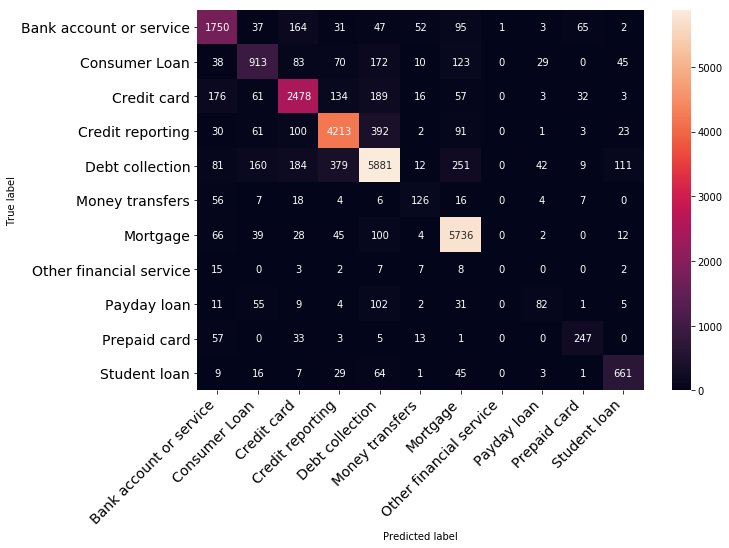

In [50]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                       sorted(labels_index.keys()))

### Single Layer CNN with Multiple Filter Widths

  A set of variable length filters are applied to a single convolution layer. Each filter yields a feature map, from which maxpooling is applied. The feature maps resulting from different filters are concatenated together and fed into softmax classifier. By using variable-length filters instead of fixed-length filters, we explore correlation between pairs, triplets, and quadruples of words to extract context meaning of combined words. The architecture could be improved by also going deeper with multiple conv layers. 

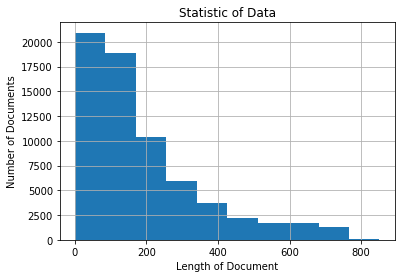

In [80]:
x_train, y_train, x_val, y_val, word_index = data_preprocessing(texts, 
                                                                labels, 
                                                                indices_consumer, 
                                                                num_validation_samples_c, 
                                                                classifier="NeuralNetwork")

In [81]:
embedding_matrix, num_words = get_embedding_matrix(word_index)

In [89]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

with graph.as_default():
    #Pretrained
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a 1D convnet with global maxpooling
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    
    filters = []
    for kw in (2, 3, 4):
        x = Conv1D(10, kw, activation='relu')(embedded_sequences)
        x = MaxPooling1D(kw)(x)
        x = Flatten()(x)
        filters.append(x)
    x = Concatenate()(filters)
    x = Dropout(0.1)(x)
    #x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=20, # Change this to at least 20 for final run
                        validation_data=(x_val, y_val))

Training model.
Train on 40084 samples, validate on 26722 samples
Epoch 1/20
40084/40084 [==============================]40084/40084 [==============================] - 67s 2ms/step - loss: 1.4064 - acc: 0.5355 - val_loss: 1.0831 - val_acc: 0.6711

Epoch 2/20
40084/40084 [==============================]40084/40084 [==============================] - 66s 2ms/step - loss: 0.8904 - acc: 0.7250 - val_loss: 0.9064 - val_acc: 0.7274

Epoch 3/20
40084/40084 [==============================]40084/40084 [==============================] - 69s 2ms/step - loss: 0.7566 - acc: 0.7694 - val_loss: 0.8272 - val_acc: 0.7549

Epoch 4/20
40084/40084 [==============================]40084/40084 [==============================] - 69s 2ms/step - loss: 0.6788 - acc: 0.7928 - val_loss: 0.9024 - val_acc: 0.7463

Epoch 5/20
40084/40084 [==============================]40084/40084 [==============================] - 69s 2ms/step - loss: 0.6249 - acc: 0.8071 - val_loss: 0.8174 - val_acc: 0.7629

Epoch 6/20
40084/40084 [

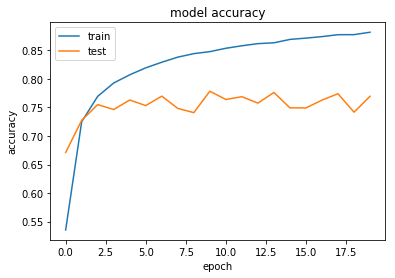

In [90]:
show_curve(history)

In [91]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result_c['CNN-Single'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

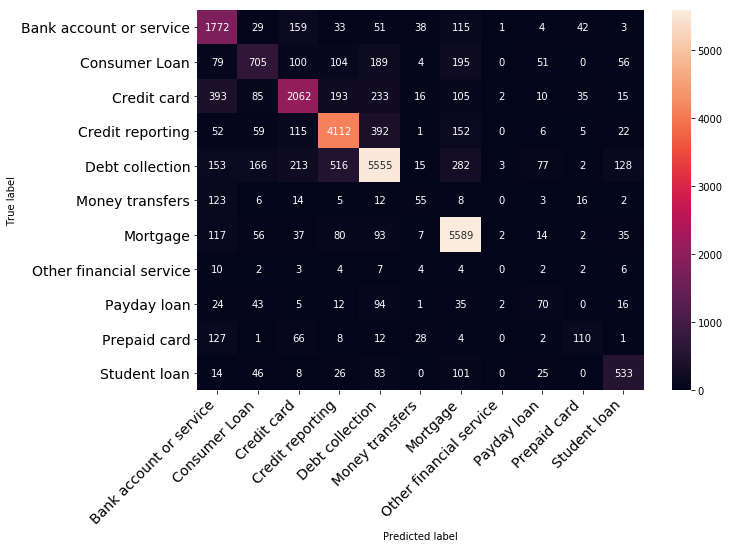

In [92]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                        sorted(labels_index.keys()))

### GRU

In [88]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a single layer LSTM recurrent neural network
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    # Replace LSTM with GRU if you want
    x,_ = GRU(EMBEDDING_DIM, return_state=True)(embedded_sequences)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=20, # Change this to at least 20 for final run
                      validation_data=(x_val, y_val))

Training model.
Train on 40084 samples, validate on 26722 samples
Epoch 1/20
40084/40084 [==============================]40084/40084 [==============================] - 186s 5ms/step - loss: 1.3464 - acc: 0.5346 - val_loss: 1.3066 - val_acc: 0.5825

Epoch 2/20
40084/40084 [==============================]40084/40084 [==============================] - 178s 4ms/step - loss: 0.7186 - acc: 0.7723 - val_loss: 0.8096 - val_acc: 0.7355

Epoch 3/20
40084/40084 [==============================]40084/40084 [==============================] - 176s 4ms/step - loss: 0.5853 - acc: 0.8158 - val_loss: 0.6207 - val_acc: 0.8007

Epoch 4/20
40084/40084 [==============================]40084/40084 [==============================] - 175s 4ms/step - loss: 0.5252 - acc: 0.8350 - val_loss: 0.5240 - val_acc: 0.8328

Epoch 5/20
40084/40084 [==============================]40084/40084 [==============================] - 177s 4ms/step - loss: 0.4810 - acc: 0.8469 - val_loss: 0.6405 - val_acc: 0.7991

Epoch 6/20
40084/40

### Multilayer GRU

In [96]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a single layer LSTM recurrent neural network
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    # Replace LSTM with GRU if you want
    x = GRU(EMBEDDING_DIM, return_sequences=True)(embedded_sequences)
    #x = GRU(EMBEDDING_DIM, return_sequences=True)(x)
    x = GRU(EMBEDDING_DIM)(x)
    #x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=10, 
                      validation_data=(x_val, y_val))

Training model.
Train on 40084 samples, validate on 26722 samples
Epoch 1/10
40084/40084 [==============================]40084/40084 [==============================] - 369s 9ms/step - loss: 1.2921 - acc: 0.5481 - val_loss: 0.9669 - val_acc: 0.6802

Epoch 2/10
40084/40084 [==============================]40084/40084 [==============================] - 357s 9ms/step - loss: 0.7085 - acc: 0.7739 - val_loss: 0.6843 - val_acc: 0.7823

Epoch 3/10
40084/40084 [==============================]40084/40084 [==============================] - 356s 9ms/step - loss: 0.5913 - acc: 0.8119 - val_loss: 0.7126 - val_acc: 0.7625

Epoch 4/10
40084/40084 [==============================]40084/40084 [==============================] - 360s 9ms/step - loss: 0.5261 - acc: 0.8325 - val_loss: 0.5960 - val_acc: 0.8110

Epoch 5/10
40084/40084 [==============================]40084/40084 [==============================] - 361s 9ms/step - loss: 0.4830 - acc: 0.8463 - val_loss: 0.5410 - val_acc: 0.8295

Epoch 6/10
40084/40

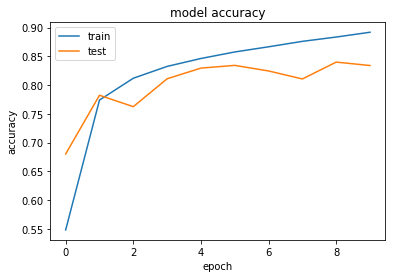

In [97]:
show_curve(history)

In [98]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result_c['MGRU'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

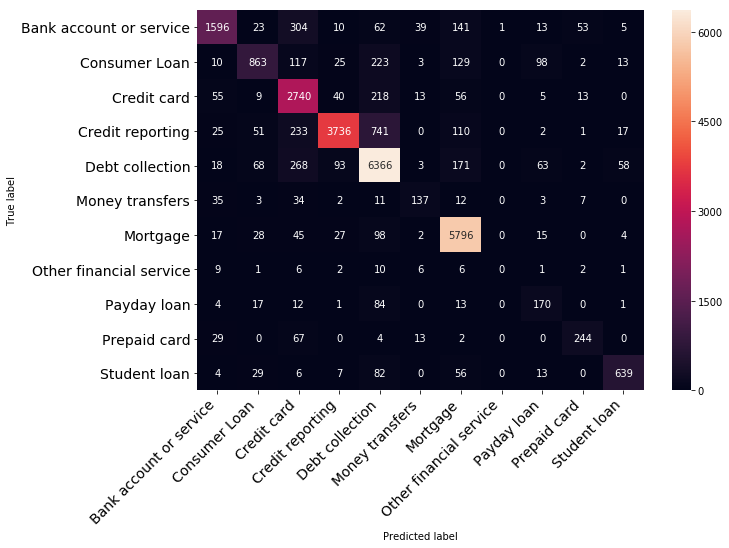

In [99]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                        sorted(labels_index.keys()))

## Show final results of different architectures on US Consumer Finance Complaints

In [8]:
def show_bar(experiment_result):
    df = pd.DataFrame(columns=['Algorithm','Score'])
    for key, value in experiment_result.items():
        df = df.append({'Algorithm': key, 'Score':value}, ignore_index=True)
    sns.barplot(x=df['Algorithm'], y=df['Score'], ci=None)
    plt.show()

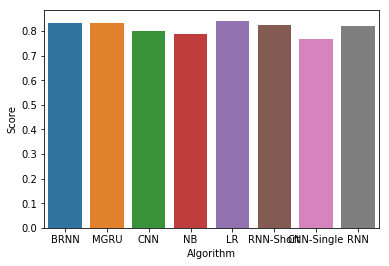

In [100]:
df = show_bar(experiment_result_c)